# Routed Sequencing with Cleanup Memory

This model extends the routed sequencing model by creating a scalar ensemble `cleanup`
as explained in the book. You will project the `state` on to the `cleanup` ensemble
using a transformation matrix `pd`, specified by the vocabulary vector **A**. This
implies
that each component of the state vector (i.e., the cortical element) is multiplied by
the corresponding component of the **A** vector and summed to produce a one dimensional
quantity represented by the `cleanup` ensemble. This operation is similar to the dot
product of the state vector and the vocabulary vector **A**.

In [1]:
# Setup for the notebook
import numpy as np

import nengo
from nengo import spa
from nengo.spa import Vocabulary

## Create the Model

This model has parameters as described in the book, with a one dimensional `cleanup`
ensemble consisting of 100 neurons.

In [2]:
# Number of dimensions for the Semantic Pointers
dim = 16

# Change the seed of this RNG to change the vocabulary
rng = np.random.RandomState(4)
vocab = Vocabulary(dimensions=dim, rng=rng, max_similarity=0.1)

# Make a model object with the SPA network
model = spa.SPA(label="Routed_Sequence with cleanupA", vocabs=[vocab])

# Create the spa.SPA network to which we can add SPA objects
with model:
    # Specifying the modules to be used
    model.state = spa.State(dimensions=dim, feedback=1, feedback_synapse=0.01)
    model.vision = spa.State(dimensions=dim)

    # Specify the action mapping
    actions = spa.Actions(
        "dot(vision, START) --> state = vision",
        "dot(state, A) --> state = B",
        "dot(state, B) --> state = C",
        "dot(state, C) --> state = D",
        "dot(state, D) --> state = E",
        "dot(state, E) --> state = A",
    )

    # Creating the BG and thalamus components that confirm to the specified rules
    model.bg = spa.BasalGanglia(actions=actions)
    model.thal = spa.Thalamus(model.bg)

    # Get the transformation matrix (pd) and create the cleanup ensemble (cleanup)
    pd = [model.get_output_vocab("state")["A"].v.tolist()]
    model.cleanup = nengo.Ensemble(n_neurons=100, dimensions=1)

    # Function that provides the model with an initial input semantic pointer.
    def start(t):
        if t < 0.4:
            return "0.8*START+D"
        return "0"

    # Input
    model.input = spa.Input(vision=start)

    # Projecting the state of the cortex on to the cleanup ensemble using a
    # transformation matrix 'pd'.
    nengo.Connection(model.state.output, model.cleanup, transform=pd)

## Run the Model

In [ ]:
# Import the nengo_gui visualizer to run and visualize the model.
from nengo_gui.ipython import IPythonViz

IPythonViz(model, "ch7-spa-sequence-routed-cleanup.py.cfg")

Press the play button in the visualizer to run the simulation. You should see the graphs
as shown in the figure below.

The graph on the bottom-left shows the semantic pointer representation of the values
stored in the `state` and the response of the `cleanup` population is shown in the plot
on the bottom-right. The plot on the top-right shows the utility (similarity) of the
current Basal Ganglia input (i.e., `state`) with the possible vocabulary vectors. Since
the cleanup operation is similar to a dot product between the state of the cortical
element (`state`) and the defined vocabulary vector **A**, the value of the `cleanup`
population rises only when the `state` (top-right graph) is **A**.

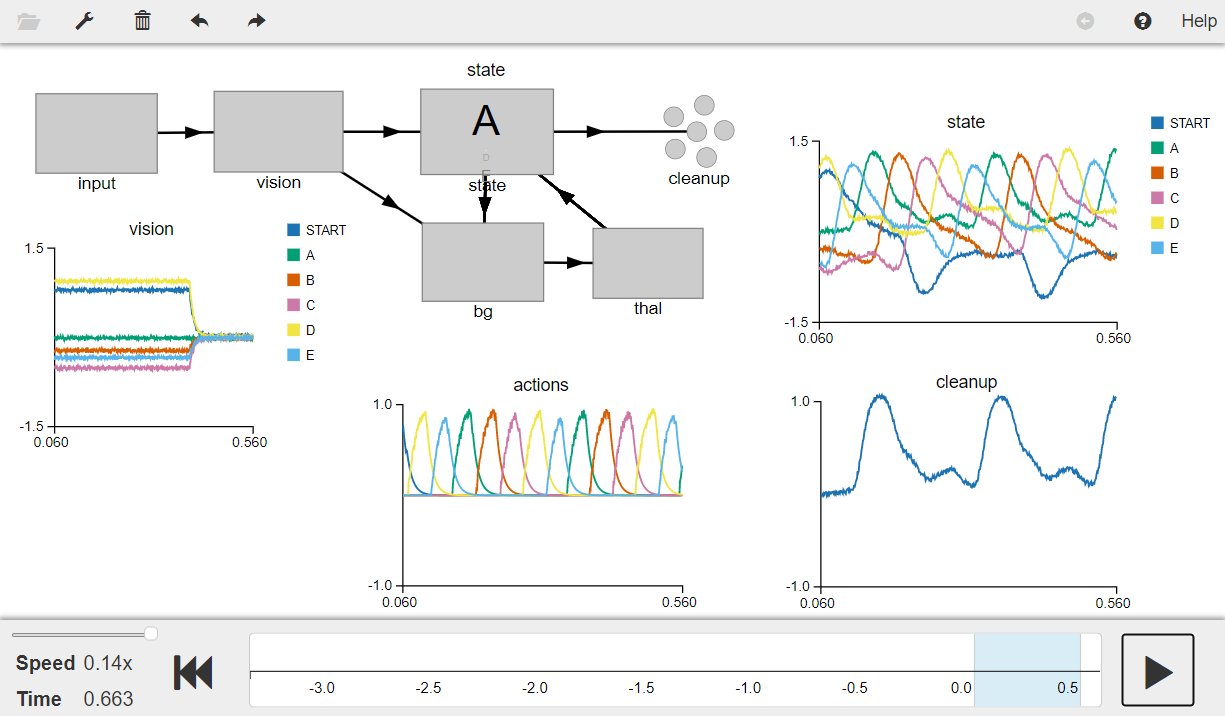

In [3]:
from IPython.display import Image

Image(filename="ch7-spa-sequence-routed-cleanup.png")